In [63]:
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from itertools import product
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
data = fetch_openml('mnist_784', version=1)

In [3]:
Xdata, ydata = data.data, data.target
Xdata = Xdata.iloc[:500]
ydata = ydata.iloc[:500]
ydata = ydata.astype(int)

In [4]:
Xtrain, Xtemp, ytrain, ytemp = train_test_split(Xdata, ydata, test_size=0.3, random_state=42, stratify=ydata)
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, test_size=0.4, random_state=42, stratify=ytemp)

In [5]:
# hyperparameters

grid_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# support vector machine

In [6]:
best_model = None
best_params = None
best_val_acc = 0
val_accs = []

In [7]:
param_combinations = product(grid_params['C'], grid_params['gamma'], grid_params['kernel'])

for C, gamma, kernel in param_combinations:
    svm = SVC(C=C, gamma=gamma, kernel=kernel)
    svm.fit(Xtrain, ytrain)
    pred = svm.predict(Xval)
    val_acc = accuracy_score(yval, pred)
    val_accs.append(val_acc)
    #print(f"Params: C={C}, gamma={gamma}, kernel={kernel} | Evaluation Accuracy: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = svm
        best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}

print("Best hyperparameters:", best_params)
print("HIghest validation accuracy:", best_val_acc)

Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
HIghest validation accuracy: 0.9222222222222223


In [8]:
# test_pred = best_model.predict(Xtest)
# test_acc = accuracy_score(ytest, test_pred)
# print(f"Final Test Accuracy: {test_acc:.4f}")


# 2. PCA + SVM

In [9]:
grid_params_pca = {
    'components': [10, 15, 35, 50, 75, 100],
    'C': [0.1, 1, 10],
    'gamma': ['scale'],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

In [10]:
pca = PCA()
Xtrain_pca = pca.fit_transform(Xtrain)
Xval_pca = pca.transform(Xval)
Xtest_pca = pca.transform(Xtest)

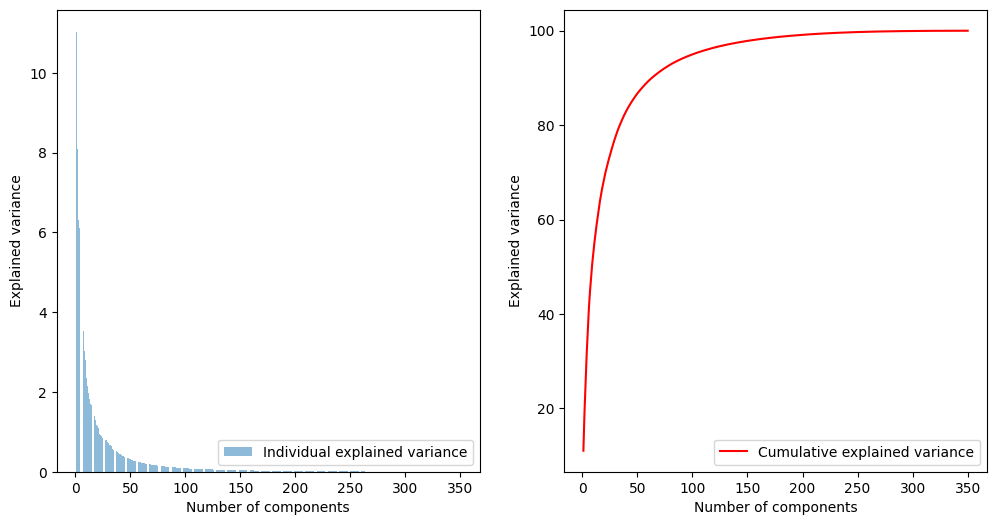

In [11]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, alpha=0.5, label='Individual explained variance')
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 'r-', label='Cumulative explained variance')


ax1.set_ylabel('Explained variance')
ax2.set_ylabel('Explained variance')
ax1.set_xlabel('Number of components')
ax2.set_xlabel('Number of components')
ax1.legend(loc='lower right')
ax2.legend()

In [12]:
best_model_pca = None
best_params_pca = None
best_val_acc_pca = 0
val_accs_pca = []

In [13]:
grid_params_pca = {
    'components': [12, 16, 42, 70, 140],
    'C': [0.1, 1, 10],
    'gamma': ['scale'],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

param_combinations_pca = product(
    grid_params_pca['components'], 
    grid_params_pca['C'], 
    grid_params_pca['gamma'], 
    grid_params_pca['kernel']
)

In [14]:
for components, C, gamma, kernel in param_combinations_pca:
    pipeline = Pipeline([
        ('pca', PCA(n_components=components)),
        ('svc', SVC(C=C, gamma=gamma, kernel=kernel))
    ])
    
    pipeline.fit(Xtrain, ytrain)
    pred = pipeline.predict(Xval)
    val_acc = accuracy_score(yval, pred)
    val_accs_pca.append(val_acc)
    #print(f"Params: Components={components}, C={C}, gamma={gamma}, kernel={kernel} | Evaluation Accuracy: {val_acc:.4f}")
    
    if val_acc > best_val_acc_pca:
        best_val_acc_pca = val_acc
        best_model_pca = pipeline
        best_params_pca = {'components': components, 'C': C, 'gamma': gamma, 'kernel': kernel}

print("Best hyperparameters:", best_params_pca)
print("HIghest validation accuracy:", best_val_acc_pca)

Best hyperparameters: {'components': 70, 'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
HIghest validation accuracy: 0.9222222222222223


## 2.1 Components & classes visualization

In [15]:
unique_labels = sorted(ytrain.unique())
label_to_num = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = [label_to_num[label] for label in ytrain]


In [16]:
pca_tmp = PCA(n_components=best_params_pca['components'])

pca_viz_data = pca_tmp.fit_transform(Xtrain)

/tmp/ipykernel_40340/3711919388.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(plt.cm.tab10, len(unique_labels))


Text(0, 0.5, 'Component 4')

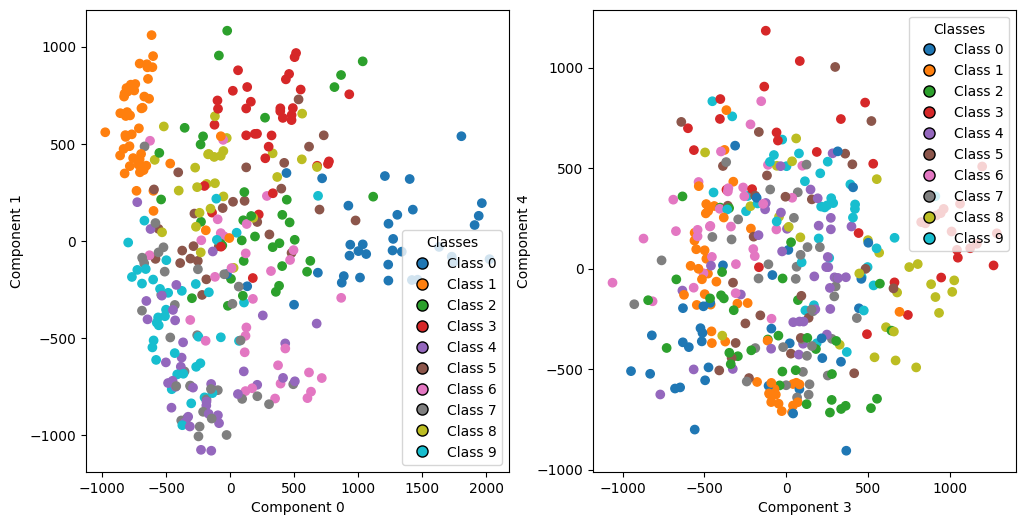

In [30]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cmap = plt.cm.get_cmap(plt.cm.tab10, len(unique_labels))

comp0, comp1 = 0, 1
sc1 = ax1.scatter(pca_viz_data[:, comp0], pca_viz_data[:, comp1], c=numeric_labels, 
           cmap=cmap
          )
comp2, comp3 = 3, 4
sc2 = ax2.scatter(pca_viz_data[:, comp2], pca_viz_data[:, comp3], c=numeric_labels, 
           cmap=cmap
          )

legend_handles = []
for idx, label in enumerate(unique_labels):
    color = cmap(idx)  # color corresponding to the class index
    # Create a 'Line2D' (or you can use mpatches.Patch) for the legend
    handle = Line2D(
        [0], [0], 
        marker='o', 
        color='none',
        markerfacecolor=color, 
        label=f'Class {label}',
        markersize=8
    )
    legend_handles.append(handle)

# Add legend to one of the axes (e.g., ax1)
ax1.legend(handles=legend_handles, title='Classes', loc='best')
ax2.legend(handles=legend_handles, title='Classes', loc='best')

ax1.set_xlabel(f'Component {comp0}')
ax1.set_ylabel(f'Component {comp1}')
ax2.set_xlabel(f'Component {comp2}')
ax2.set_ylabel(f'Component {comp3}')

## 2.2 Decision boundaries visualization

In [45]:
pca_model = best_model_pca.named_steps['pca']
pca_boundary_data = pca_model.transform(Xval)
svm_model = best_model_pca.named_steps['svc']
baseline = pca_boundary_data.mean(axis=0)

def get_data_decision_boundary(feature0, feature1):
    f1_min, f1_max = pca_boundary_data[:, feature0].min() - 1, pca_boundary_data[:, feature0].max() + 1
    f2_min, f2_max = pca_boundary_data[:, feature1].min() - 1, pca_boundary_data[:, feature1].max() + 1
    num_points = 400  # resolution of the grid

    f1_values = np.linspace(f1_min, f1_max, num_points)
    f2_values = np.linspace(f2_min, f2_max, num_points)

    f1_grid, f2_grid = np.meshgrid(f1_values, f2_values)
    grid_points = np.tile(baseline, (num_points * num_points, 1))  # shape = (num_points^2, 70)
    grid_points[:, feature0] = f1_grid.ravel()
    grid_points[:, feature1] = f2_grid.ravel()

    Z = svm_model.predict(grid_points)
    Z = Z.reshape(f1_grid.shape)
    return f1_grid, f2_grid, Z

ax1_feature1, ax1_feature2, ax2_feature1, ax2_feature2 = 0, 1, 10, 4
f1_grid_1, f2_grid_1, Z_1 = get_data_decision_boundary(ax1_feature1, ax1_feature2)
f1_grid_2, f2_grid_2, Z_2 = get_data_decision_boundary(ax2_feature1, ax2_feature2)

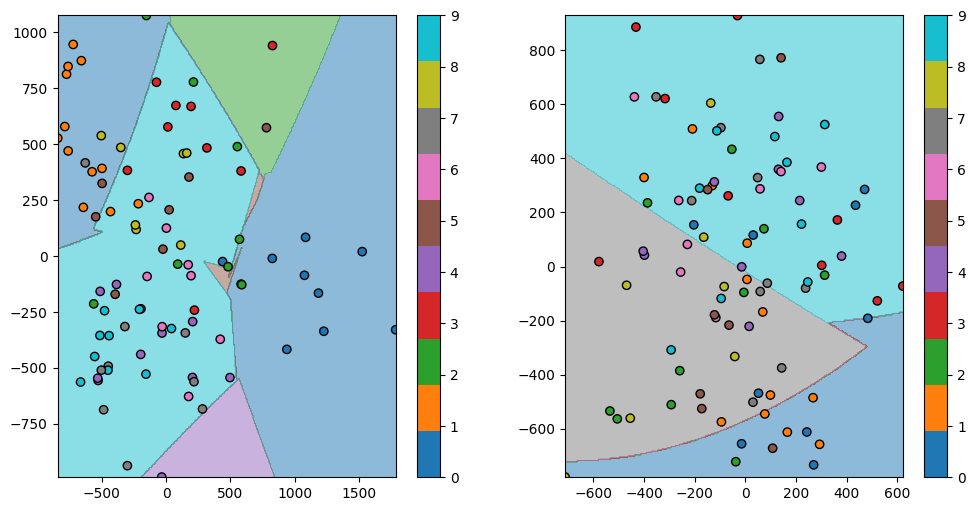

In [49]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.contourf(f1_grid_1, f2_grid_1, Z_1, alpha=0.5, cmap=plt.cm.tab10)
ax2.contourf(f1_grid_2, f2_grid_2, Z_2, alpha=0.5, cmap=plt.cm.tab10)

sc1 = ax1.scatter(pca_boundary_data[:, ax1_feature1], pca_boundary_data[:, ax1_feature2], c=yval, edgecolor='k', cmap=plt.cm.tab10)
sc2 = ax2.scatter(pca_boundary_data[:, ax2_feature1], pca_boundary_data[:, ax2_feature2], c=yval, edgecolor='k', cmap=plt.cm.tab10)

plt.colorbar(sc1, ax=ax1)
plt.colorbar(sc2, ax=ax2)

## 2.3 Confusion matrix

In [54]:
pca_model = best_model_pca.named_steps['pca']
Xtest_pca = pca_model.transform(Xtest)
svm_model = best_model_pca.named_steps['svc']

In [55]:
Xtest_pca.shape, Xtest.shape

((60, 70), (60, 784))

In [56]:
pred = svm_model.predict(Xtest_pca)

In [59]:
cm = confusion_matrix(ytest, pred)

In [71]:
Xtest.shape

(60, 784)

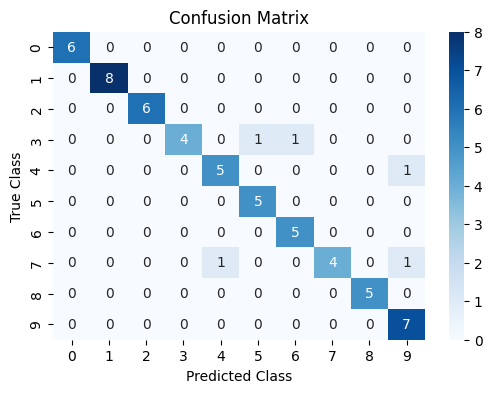

In [70]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class");


# 3. LDA + SVM

In [27]:
lda = LDA(n_components=len(ydata.unique())-1)  # Reduce to 9 components (since we have 10 classes)
Xtrain_lda = lda.fit_transform(Xtrain, ytrain)
Xval_lda = lda.transform(Xval)
Xtest_lda = lda.transform(Xtest)

In [28]:
best_model_lda = None
best_params_lda = None
best_val_acc_lda = 0
val_accs_lda = []

In [29]:
param_combinations_lda = product(grid_params['C'], grid_params['gamma'], grid_params['kernel'])

for C, gamma, kernel in param_combinations_lda:
    svm = SVC(C=C, gamma=gamma, kernel=kernel)
    svm.fit(Xtrain_lda, ytrain)
    pred = svm.predict(Xval_lda)
    val_acc = accuracy_score(yval, pred)
    val_accs_lda.append(val_acc)
    #print(f"Params: C={C}, gamma={gamma}, kernel={kernel} | Evaluation Accuracy: {val_acc:.4f}")
    
    if val_acc > best_val_acc_lda:
        best_val_acc_lda = val_acc
        best_model_lda = svm
        best_params_lda = {'C': C, 'gamma': gamma, 'kernel': kernel}

print("Best hyperparameters:", best_params_lda)
print("HIghest validation accuracy:", best_val_acc_lda)

Best hyperparameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
HIghest validation accuracy: 0.6666666666666666
